In [1]:
import os
import pandas as pd
import pathlib

curr_path = os.path.abspath('..')
folder_path = os.path.join(curr_path, 'Datasets/')
data_path = os.path.join(folder_path, 'TransReadData_en')
stopwords_path = os.path.join(curr_path, 'DataExploration','newsela_stopwords.txt')
with open(stopwords_path, 'r') as f:
    stopwords = f.read().split()

In [2]:
import glob
import numpy as np
from textstat import flesch_reading_ease, flesch_kincaid_grade, automated_readability_index
import re

f_grade = []
f_ease = []
ari = []
avg_tokenlength = []
documentlength_token = []
documentlength_sentence = []
avg_sentencelength_char = []
avg_sentencelength_token = []
grade_level = []

text_path = os.path.join(data_path, '*.txt')
filename = []
simple_txt = []
advanced_txt = []
for fname in glob.glob(text_path):
    # 0 is simple, 1 is advanced
    with open(fname, 'r', encoding='utf-8') as f:
        text = f.read()
        
    if 'simple' in fname:
        grade_level.append(0)
        simple_txt.append(text)
    else:
        grade_level.append(1)
        advanced_txt.append(text)
        
    tokens = [w for w in re.split('\.|\\n|\s', text) if w != '']
    sentences = [s for s in re.split('\.|\\n', text) if s!= '']
    filename.append(fname.split('/')[-1])
    
    f_grade.append(flesch_kincaid_grade(text))
    f_ease.append(flesch_reading_ease(text))
    ari.append(automated_readability_index(text))
    documentlength_token.append(len(tokens))
    documentlength_sentence.append(len(sentences))
    avg_tokenlength.append(np.mean([len(t) for t in tokens]))
    avg_sentencelength_char.append(np.mean([len(s) for s in sentences]))
    avg_sentencelength_token.append(np.mean([len(s.split()) for s in sentences]))

trans_read = {'filename':filename,'grade_level': grade_level, 'f_grade': f_grade, 'f_ease': f_ease,
              'ari':ari,'avg_tokenlength':avg_tokenlength, 'documentlength_token':documentlength_token,
              'documentlength_sentence':documentlength_sentence,'avg_tokenlength':avg_tokenlength,
              'avg_sentencelength_char':avg_sentencelength_char, 'avg_sentencelength_token': avg_sentencelength_token}

trans_read = pd.DataFrame(trans_read)
trans_read['slug'] = trans_read['filename'].str.replace(r'simple_','', regex=True)

Text(0.5, 1.0, 'Document Distribution Over Reading Level')

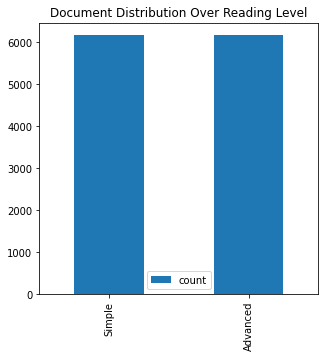

In [3]:
document_dists = {'Simple':len(simple_txt), 'Advanced':len(advanced_txt)}
document_dists = pd.DataFrame([len(simple_txt), len(advanced_txt)], columns=['count'], index=['Simple', 'Advanced'])
axs = document_dists.plot.bar(y='count', use_index=True, figsize=(5,5))
axs.set_title("Document Distribution Over Reading Level", fontsize="large")

## Heuristic Score Statistics and Visualizations

In [4]:
metric_stats = trans_read.groupby('grade_level')[['f_grade', 'f_ease', 'ari']].agg(['min', 'max', 'mean','std'])
metric_stats = metric_stats.reindex()

In [5]:
metric_stats

f_grade                              f_ease                     \
                min    max       mean       std     min     max       mean   
grade_level                                                                  
0              -2.7  316.1  11.596139  8.893311 -737.15  119.19  59.088167   
1               0.1  157.5  20.994339  7.690258 -335.28  106.67  26.920000   

                        ari                               
                   std  min    max       mean        std  
grade_level                                               
0            25.711052 -1.2  405.7  15.105596  11.398591  
1            22.097085 -2.0  202.1  26.948045  10.019575

Text(0.5, 0.98, 'Statistical Measures for Various Readability Assessment Metrics')

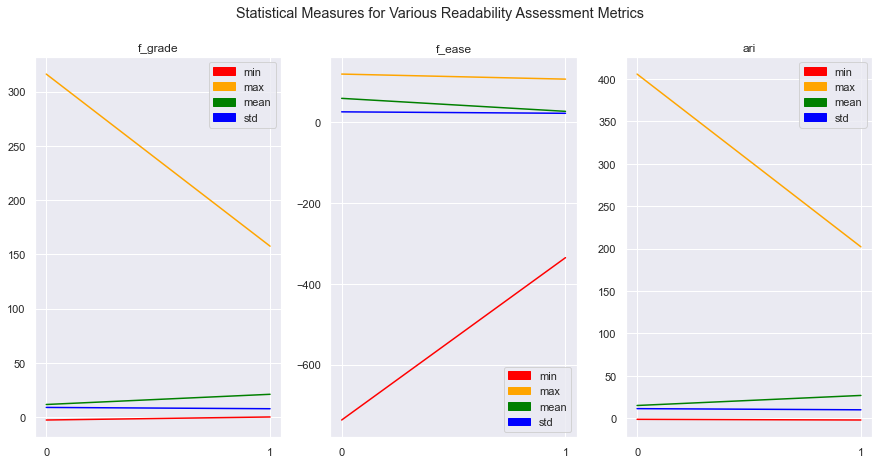

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

colors = ['red', 'orange', 'green', 'blue']
stat_types = ['min', 'max', 'mean', 'std']
score_types = ['f_grade', 'f_ease', 'ari']

fig, axs = plt.subplots(1,3, figsize=(15, 7))

x_counter = 0
y_counter = 0

for s in score_types:
    score_stats = metric_stats[s]
    score_stats = score_stats.reindex()
    patches = []
    
    for i in range(len(colors)):   
        axs[y_counter].plot(score_stats.index, score_stats[stat_types[i]], color=colors[i])
        patches.append(mpatches.Patch(color=colors[i], label=stat_types[i]))
    
    axs[y_counter].legend(handles=patches)
    axs[y_counter].set_title(s)
    axs[y_counter].set_xticks([0,1])
    
    if y_counter == 2:
        y_counter = 0
        x_counter = 1
    else:
        y_counter += 1

fig.suptitle('Statistical Measures for Various Readability Assessment Metrics')

## N-Gram and Document Lengths

In [7]:
length_stats = trans_read.groupby('grade_level')[['documentlength_token',
                                               'documentlength_sentence',
                                               'avg_tokenlength', 
                                               'avg_sentencelength_char',
                                               'avg_sentencelength_token']].agg(['min', 'max', 'mean','std'])
length_stats = length_stats.reindex()

Text(0.5, 0.98, 'Statistical Measures for Length Metrics')

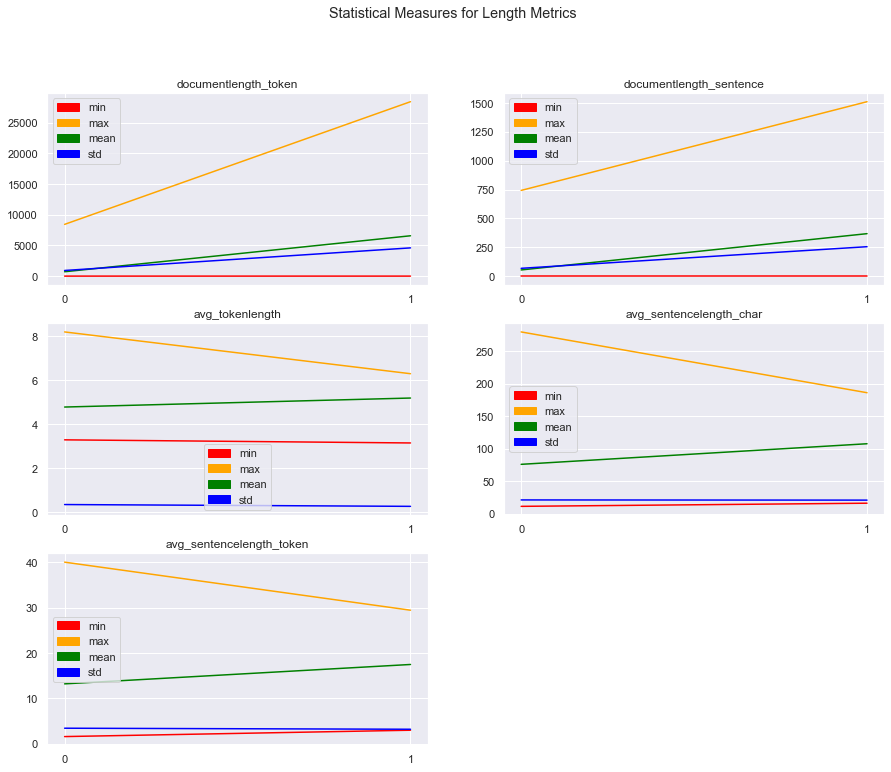

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

colors = ['red', 'orange', 'green', 'blue']
stat_types = ['min', 'max', 'mean', 'std']
score_types = ['documentlength_token','documentlength_sentence','avg_tokenlength', 'avg_sentencelength_char', 'avg_sentencelength_token']

fig, axs = plt.subplots(3,2, figsize=(15, 12))

x_counter = 0
y_counter = 0

for s in score_types:
    score_stats = length_stats[s]
    score_stats.reset_index(inplace=True)
    patches = []
    
    for i in range(len(colors)):   
        axs[x_counter, y_counter].plot(score_stats['grade_level'], score_stats[stat_types[i]], color=colors[i])
        patches.append(mpatches.Patch(color=colors[i], label=stat_types[i]))
    
    axs[x_counter, y_counter].legend(handles=patches)
    axs[x_counter, y_counter].set_title(s)
    axs[x_counter, y_counter].set_xticks([0,1])
    
    if y_counter == 1:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1
fig.delaxes(axs[2,1])
fig.suptitle('Statistical Measures for Length Metrics')

## N-Gram Analysis

c:\users\jchle\work\nrc_research\rankread\windows_venv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'estarã', 'estuviã', 'estã', 'fuã', 'habrã', 'habã', 'hayã', 'hubiã', 'mã', 'quã', 'ramos', 'semos', 'serã', 'seã', 'sã', 'tambiã', 'tendrã', 'tengã', 'tenã', 'tuviã', 'tãº'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


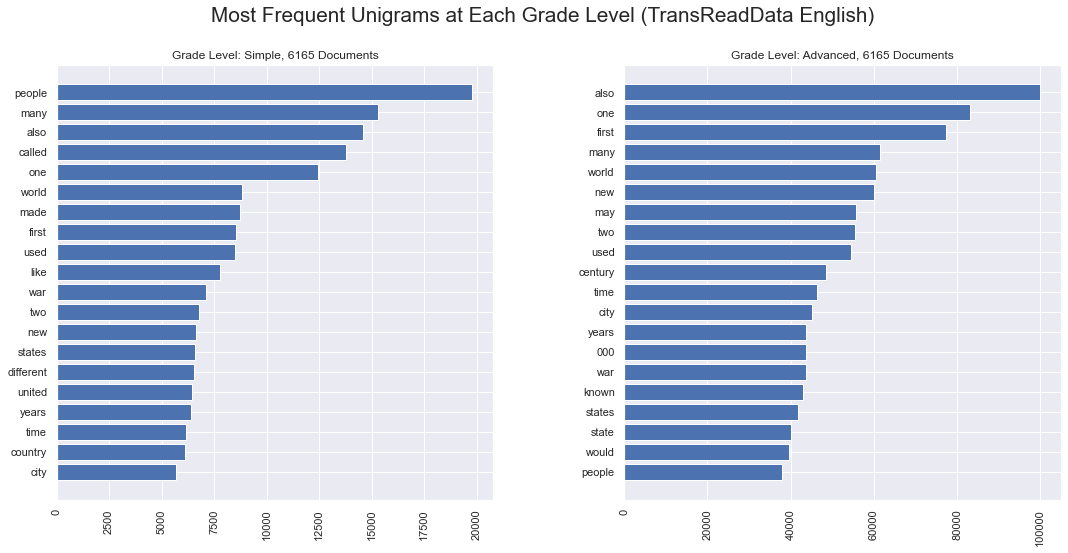

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

fig, axs = plt.subplots(1,2, figsize=(18, 8))
x_counter = 0
y_counter = 0

levels = {"Simple":simple_txt, "Advanced":advanced_txt}

for lvl,txt in levels.items():
    vectorizer = CountVectorizer(stop_words=stopwords)
    counts = np.asarray(np.sum(vectorizer.fit_transform(txt), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[y_counter].barh(keys[::-1], vals[::-1])
    axs[y_counter].tick_params(axis='x', rotation=90)
    axs[y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, len(txt)))
    
    if y_counter == 1:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Most Frequent Unigrams at Each Grade Level (TransReadData English)',fontsize='xx-large')
plt.savefig('freq_1gram_trenglish.png')

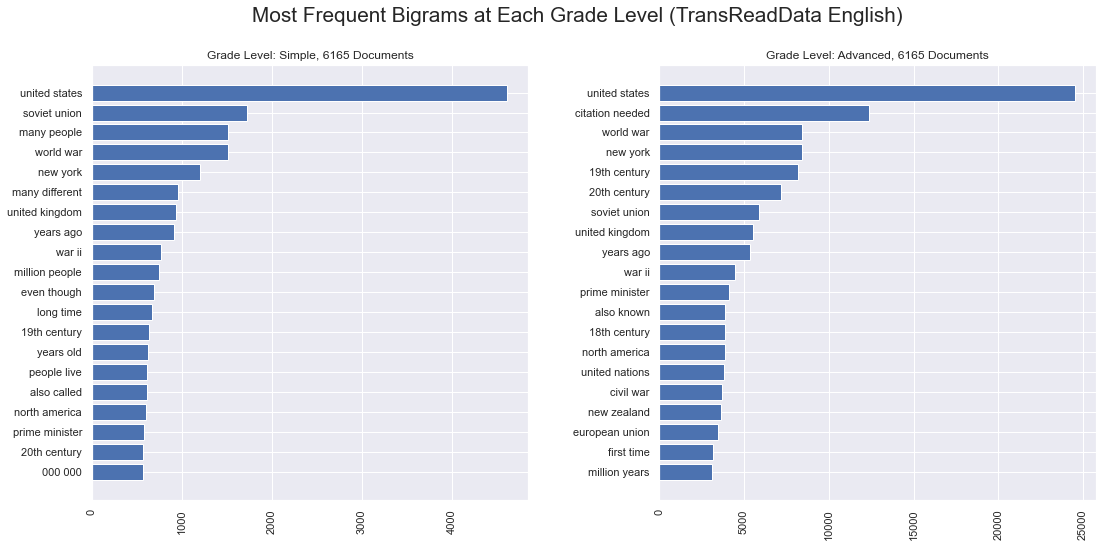

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

fig, axs = plt.subplots(1,2, figsize=(18, 8))
x_counter = 0
y_counter = 0

levels = {"Simple":simple_txt, "Advanced":advanced_txt}

for lvl,txt in levels.items():
    vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(2,2))
    counts = np.asarray(np.sum(vectorizer.fit_transform(txt), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[y_counter].barh(keys[::-1], vals[::-1])
    axs[y_counter].tick_params(axis='x', rotation=90)
    axs[y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, len(txt)))
    
    if y_counter == 2:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Most Frequent Bigrams at Each Grade Level (TransReadData English)',fontsize='xx-large')
plt.savefig('freq_2gram_trenglish.png')

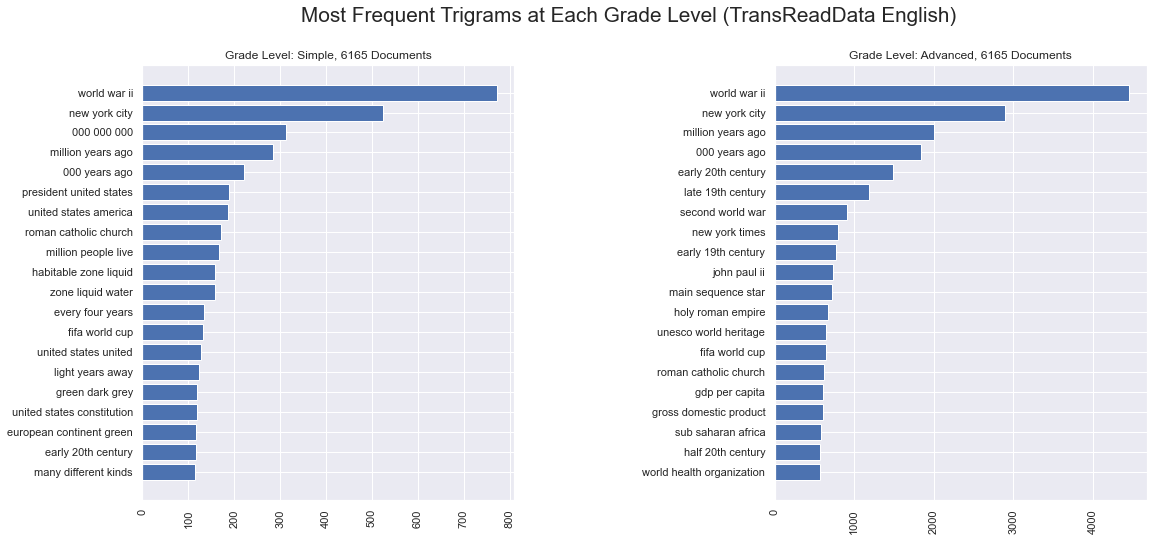

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

fig, axs = plt.subplots(1,2, figsize=(18, 8))
x_counter = 0
y_counter = 0

levels = {"Simple":simple_txt, "Advanced":advanced_txt}

for lvl,txt in levels.items():
    vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(3,3))
    counts = np.asarray(np.sum(vectorizer.fit_transform(txt), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[y_counter].barh(keys[::-1], vals[::-1])
    axs[y_counter].tick_params(axis='x', rotation=90)
    axs[y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, len(txt)))
    
    if y_counter == 2:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.7)
fig.suptitle('Most Frequent Trigrams at Each Grade Level (TransReadData English)',fontsize='xx-large')
plt.savefig('freq_3gram_trenglisha.png')

In [13]:
output_path = os.path.join(folder_path, 'tr_english_rank_features.csv')
trans_read.to_csv(output_path, index=False)